# VAE

# Dimensionality reduction with Autoencoders versus PCA

In [ ]:
!pip install spectral
!pip install rasterio 

In [ ]:
# Basic import

from time import time
import rasterio as rio
from sklearn.preprocessing import minmax_scale
from sklearn import cluster
from sklearn.decomposition import PCA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

# generate data
# X, y = datasets.make_classification(n_samples=10000, n_features=50, n_redundant=10, n_informative=10,
                          #  random_state=1, n_clusters_per_class=2,n_classes=3, class_sep=2)
                           
# # divide data in Train - Validation - Test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# # Standardize Data
# sc = StandardScaler()
# X_tr_std = sc.fit_transform(X_tr)
# X_valid_std = sc.transform(X_valid)
# X_test_std = sc.transform(X_test)

## Load and process Dataset 

In [ ]:
# Importing the data
import rasterio as rio
data_raster = rio.open('drive/MyDrive/VAE_GeoChem/Playa_Image.tif')
data_test   = rio.open('drive/MyDrive/VAE_GeoChem/Playa_Training.tif')
# print(data_raster.meta)

## Visualizing the data
# Reading and enhancing
data_array = data_raster.read() # reading the data
vmin, vmax = np.nanpercentile(data_array, (5,95)) # 5-95% pixel values stretch

data_array_test = data_test.read() # reading the data
vmin, vmax = np.nanpercentile(data_array_test, (5,95)) # 5-95% pixel values stretch
# Plotting the enhanced image
# fig = plt.figure(figsize=[20,20])
# plt.axis('off')
# plt.imshow(data_array[0, :, :], vmin=vmin, vmax=vmax)
# plt.show()

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
## Reshaping the traindata from brc to rcb
# Creating an empty array with the same dimension and data type
imgxyb = np.empty((data_raster.height, data_raster.width, data_raster.count), data_raster.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = data_raster.read(band+1)

# Reshaping the train data from rcb to samples and features
data_reshaped = imgxyb.reshape(imgxyb.shape[0]*imgxyb.shape[1], -1)
# Scaling
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
data_reshaped.shape

(188788, 7)

In [ ]:
## Reshaping the test data from brc to rcb
# Creating an empty array with the same dimension and data type
imgxyb_test = np.empty((data_test.height, data_test.width, data_test.count), data_test.meta['dtype'])
# Looping through the bands to fill the empty array
for band in range(imgxyb_test.shape[2]):
    imgxyb_test[:,:,band] = data_test.read(band+1)

# Reshaping the test data from rcb to samples and features
data_reshaped_test = imgxyb_test.reshape(imgxyb_test.shape[0]*imgxyb_test.shape[1], -1)
# Scaling
data_reshaped_test = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
data_reshaped_test.shape

(188788, 7)

In [ ]:
# divide data in Train - Validation - Test
X_train, X_test, y_train, y_test = train_test_split(data_reshaped, data_reshaped_test, test_size=0.3, random_state=42)
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# Standardize Data
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

## Let’s set up this AE: 

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[7]),
    # keras.layers.Dense(7, input_shape=[8]),
    # keras.layers.Dense(6, input_shape=[7]),
    # keras.layers.Dense(5, input_shape=[6]),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(7, input_shape=[5]),
    # keras.layers.Dense(7, input_shape=[6]),
    # keras.layers.Dense(8, input_shape=[7]),
    # keras.layers.Dense(9, input_shape=[8]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.01))

history = autoencoder.fit(X_tr_std,X_tr_std, epochs=10,validation_data=(X_valid_std,X_valid_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
                         
codings = encoder.predict(X_tr_std)

Epoch 1/10
3304/3304 [==============================] - 7s 2ms/step - loss: 0.0427 - val_loss: 0.0069
Epoch 2/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 3/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 4/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 5/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.001

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


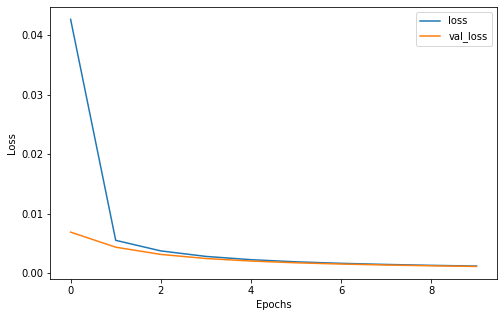

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig("summarize history for loss.jpg")

## PCA implementation:

In [ ]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=5,svd_solver='auto')
# scores = pca.fit_transform(X_tr_std) # u

# PCA
pca = PCA(n_components=data_array.shape[0])
scores = pca.fit_transform(data_reshaped)
var_ratio = pca.explained_variance_ratio_
values = pca.singular_values_

print(var_ratio.shape)
print(values)

(7,)
[186.32807025 118.64892902  17.88859731  10.84392844   3.67100249
   1.82416551   0.85764981]


In [ ]:
# function to plot and display the image
def plot_data(data,fig_name):
  fig = plt.figure(figsize = (15, 10))
  plt.imshow(data, cmap = 'nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
  plt.savefig(fig_name)

# Clustring

# a. PCA -> K-means 

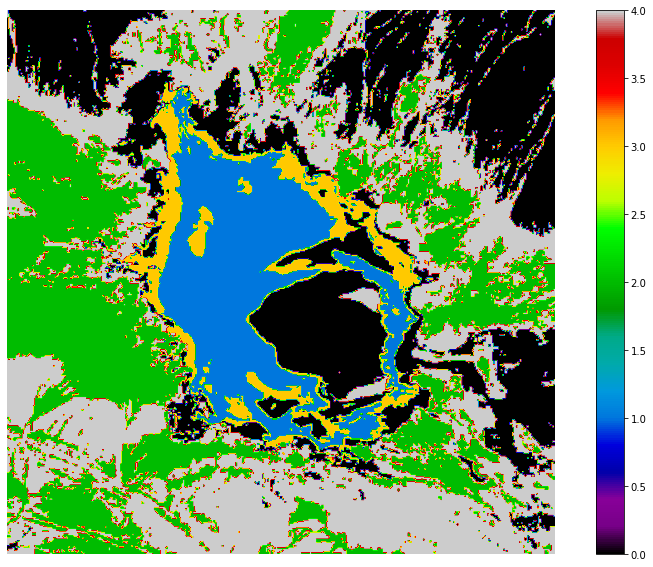

<Figure size 432x288 with 0 Axes>

In [ ]:
# K-means
cl = cluster.KMeans(n_clusters=5) # Creating an object of the classifier
components_num = 5
param = cl.fit(scores[:,:components_num]) # Training
img_c = cl.labels_ # Getting the labels of the classes
img_cl = img_c.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_cl, 'PCA_k_means.png')

## b. AE -> K-means

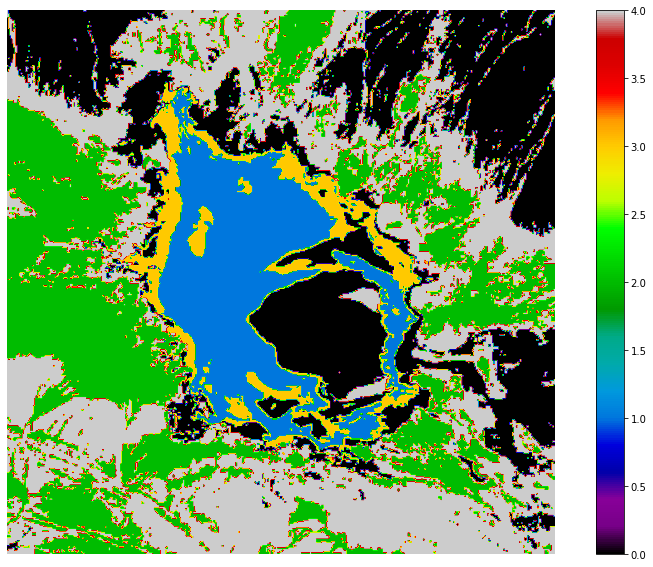

<Figure size 432x288 with 0 Axes>

In [ ]:
# K-means
cl = cluster.KMeans(n_clusters=10) # Creating an object of the classifier
param = cl.fit(codings) # Training
img_c = cl.labels_ # Getting the labels of the classes
# img_cl_pred = cl.predict(data_ae)
img_c2 = img_cl.reshape(data_array[0,:,:].shape) # Reshaping the labels to a 3D array (single band)
plot_data(img_c2, 'AE_k_means.png')

In [ ]:
codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

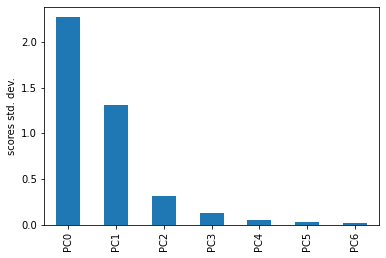

In [ ]:
pd.DataFrame(scores_train, columns=['PC'+str(i) for i in range(pca.n_components_)]).std().plot(kind='bar', color='tab:blue')
plt.ylabel('scores std. dev.');
plt.savefig('scores_std_dev.png')
# plt.savefig("summarize history for loss.jpg")

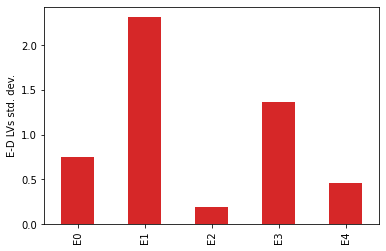

In [ ]:
pd.DataFrame(codings_train, columns=['E'+str(i) for i in range(5)]).std().plot(kind='bar', color='tab:red')
plt.ylabel('E-D LVs std. dev.')
plt.savefig('E-D_LVs_std_dev.png')

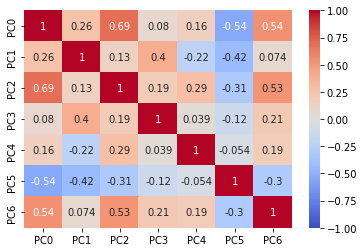

In [ ]:
sns.heatmap(pd.DataFrame(scores_train, columns=['PC'+str(i) for i in range(pca.n_components_)]).corr(), vmin=-1, vmax=+1, cmap='coolwarm', annot=True)

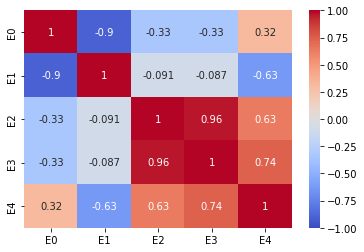

In [ ]:
sns.heatmap(pd.DataFrame(codings_train, columns=['E'+str(i) for i in range(5)]).corr(), vmin=-1, vmax=+1, cmap='coolwarm', annot=True)

In [ ]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 5)                 40        
                                                                 
 sequential_1 (Sequential)   (None, 7)                 42        
                                                                 
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


## NonLinear Stacked Encoder-Decoder
The nonlinear stacked AE will be easily implemented as the stacked AE but with an activation function. We also introduced a decay constant over the SGD optimizer so that the learning rate will decrease over time. We pick “selu” as activation layer for all layers. Note that here we have increased the complexity even more: we could try to find the best number of hidden layers, the best activation function and shape of each of the layers for the specific problem.

In [ ]:
nl_st_encoder = keras.models.Sequential([
    keras.layers.Dense(6, input_shape=[7], activation='relu'),
    keras.layers.Dense(5, activation='selu'),
    keras.layers.Dense(5, activation='selu'),
])

nl_st_decoder = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=[5], activation='selu'),
    keras.layers.Dense(6, activation='selu'),
    keras.layers.Dense(7, activation='relu'),
])

nl_st_autoencoder = keras.models.Sequential([nl_st_encoder, nl_st_decoder])
nl_st_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4))
nl_st_autoencoder.summary()


history = nl_st_autoencoder.fit(X_tr_std,X_tr_std, epochs=10,validation_data=(X_valid_std,X_valid_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)],verbose=1)

nl_st_codings_train = nl_st_encoder.predict(X_tr_std)
nl_st_codings_test = nl_st_encoder.predict(X_test_std)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 5)                 113       
                                                                 
 sequential_7 (Sequential)   (None, 7)                 115       
                                                                 
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


3304/3304 [==============================] - 7s 2ms/step - loss: 0.7200 - val_loss: 0.7118
Epoch 2/10
3304/3304 [==============================] - 6s 2ms/step - loss: 0.6951 - val_loss: 0.7106
Epoch 3/10
3304/3304 [==============================] - 7s 2ms/step - loss: 0.6937 - val_loss: 0.7035
Epoch 4/10
3304/3304 [==============================] - 8s 2ms/step - loss: 0.6846 - val_loss: 0.7002
Epoch 5/10
3304/3304 [==============================] - 7s 2ms/step - loss: 0.6840 - val_loss: 0.6999
Epoch 6/10
3304/3304 [==============================] - 7s 2ms/step - loss: 0.6838 - val_loss: 0.6998
Epoch 7/10
3304/3304 [==============================] - 7s 2ms/step - loss: 0.6837 - val_loss: 0.6997
Epoch 8/10
3304/3304 [==============================] - 7s 2ms/step - loss: 0.6836 - val_loss: 0.6996
Epoch 9/10
3304/3304 [==============================] - 8s 3ms/step - loss: 0.6835 - val_loss: 0.6995
Epoch 10/10
3304/3304 [==============================] - 7s 2ms/step - loss: 0.6834 - val_los

# Conclusion 
Our aim was to compare PCA and an AutoEncoder neural network to see if the dimensionality reduction was comparable.

- We looked at the properties of the scores/encodings and we saw that encodings from the AE have some correlations (the covariant matrix is not diagonal like in PCA), and also that their standard deviation is similar.
Starting from a simple linear undercomplete AE with just 1 layer, we saw that increasing complexity helped the model reach better performances, evaluated in terms of classification accuracy.
- Finally, we saw that a non linear model can still perform better than the other two (one layer AE and stacked AE) but the performance is still comparable to that of PCA in this dataset.

https://github.com/rasbt/deeplearning-models/tree/master/pytorch_ipynb/autoencoder